In [1]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

import pyro
import pyro.contrib.gp as gp

import torch.optim as optim

import torch.autograd as autograd

# Objective function

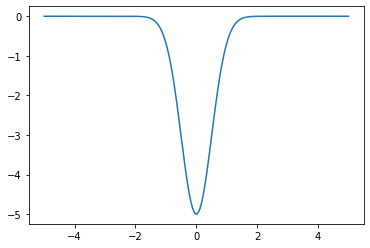

In [2]:
a = -5
b = 0
c = 0.5

def test_function(X):
    return a * torch.exp(-1.0 * torch.pow((X - b), 2) / (2*c*c))

x_ = torch.linspace(-5, 5, 200)

plt.plot(x_, test_function(x_))

# Training data

In [3]:
train_cnt = 3
X_train = torch.tensor([x for x in np.random.uniform(low=-5, high=5, size=train_cnt)])
Y_train = test_function(X_train)

# Model

In [4]:
gpmodel = gp.models.GPRegression(X_train.T, Y_train, 
                                 gp.kernels.Matern52(input_dim=1, lengthscale=torch.ones(1), variance=torch.Tensor([150.0])), 
                                 noise=torch.tensor(0.1), 
                                 jitter=1.0e-4)

# Expected improvement

In [5]:
normal_phi = lambda x: torch.exp(-x.pow(2)/2)/np.sqrt(2*np.pi)
normal_Phi = lambda x: (1 + torch.erf(x / np.sqrt(2))) / 2
  
def expected_improvement(x):
    
    y_min = gpmodel.y.min()
    
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    
    sigma = variance.sqrt()
    
    delta = y_min - mu
    
    EI = delta.clamp_min(0.0) + sigma*normal_phi(delta/sigma) - delta.abs()*normal_Phi(delta/sigma)
    
    return -EI

# Lower confidence bound

In [6]:
def lower_confidence_bound(x, kappa=2):
    
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

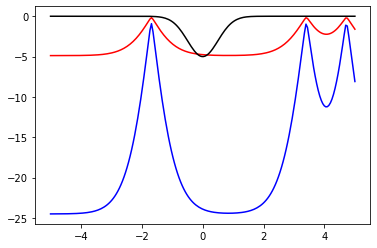

In [7]:
plt.plot(x_, expected_improvement(x_).detach().numpy(), color="red")
plt.plot(x_, lower_confidence_bound(x_).detach().numpy(), color="blue")
plt.plot(x_, test_function(x_), color="black")

# Minimising acquisition function

In [8]:
acquisition_func = expected_improvement
# acquisition_func = lower_confidence_bound

x_st = torch.Tensor([0.5]).detach().requires_grad_(True)

# unconstrained minimiser
minimizer = optim.LBFGS([x_st])

def closure():
    # clear gradients
    minimizer.zero_grad()

    y = acquisition_func(x_st)

    autograd.backward(x_st, autograd.grad(y, x_st))
    
    print("x_st", x_st)
    
    return y

minimizer.step(closure)

x_st tensor([0.5000], requires_grad=True)
x_st tensor([0.5719], requires_grad=True)
x_st tensor([0.7825], requires_grad=True)
x_st tensor([0.8362], requires_grad=True)
x_st tensor([0.8433], requires_grad=True)


tensor([-4.8507], grad_fn=<NegBackward>)

In [9]:
acquisition_func = lower_confidence_bound

x_st = torch.Tensor([0.5]).detach().requires_grad_(True)

# unconstrained minimiser
minimizer = optim.LBFGS([x_st])

def closure():
    # clear gradients
    minimizer.zero_grad()

    y = acquisition_func(x_st)

    autograd.backward(x_st, autograd.grad(y, x_st))
    
    print("x_st", x_st)
    
    return y

minimizer.step(closure)

x_st tensor([0.5000], requires_grad=True)
x_st tensor([0.8643], requires_grad=True)
x_st tensor([0.8488], requires_grad=True)
x_st tensor([0.8462], requires_grad=True)


tensor([-24.3575], grad_fn=<SubBackward0>)